In [ ]:
!pip install gdown tensorflow scikit-learn matplotlib Pillow numpy

In [ ]:
import gdown
import zipfile

gdown.download("https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ", "dataset.zip", quiet=False)
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()
    print("Dataset extraído exitosamente.")


Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=50a19101-6dcd-4911-879f-e3389498704c
To: /content/dataset.zip
100%|██████████| 363M/363M [00:02<00:00, 167MB/s]


Dataset extraído exitosamente.


In [8]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Input, Add, Dropout,
    BatchNormalization, Activation, GlobalAveragePooling2D, Rescaling,
    RandomFlip, RandomRotation, RandomZoom
)
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping

from PIL import Image
import ssl

# Desactiva la verificación SSL para evitar errores de descarga
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
import os
import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt

class DatasetLoader:
    """
    Clase encargada de cargar y preprocesar los conjuntos de datos de entrenamiento, prueba y predicción.
    """
    def __init__(self, train_directory, test_directory, prediction_directory, image_height=150, image_width=150, batch_size=32):
        """
        Inicializa el cargador de datasets con las rutas y parámetros necesarios.

        :param train_directory: Ruta al directorio de datos de entrenamiento.
        :param test_directory: Ruta al directorio de datos de prueba.
        :param prediction_directory: Ruta al directorio de datos de predicción.
        :param image_height: Altura de las imágenes (default 150).
        :param image_width: Ancho de las imágenes (default 150).
        :param batch_size: Tamaño del batch para la carga de datos (default 32).
        """
        self.train_directory = train_directory
        self.test_directory = test_directory
        self.prediction_directory = prediction_directory
        self.image_height = image_height
        self.image_width = image_width
        self.batch_size = batch_size
        self.train_ds = None
        self.test_ds = None
        self.pred_ds = None
        self.class_names = None

    def load_train_test_data(self):
        """
        Carga y preprocesa los datos de entrenamiento y prueba.
        """
        try:
            self.train_ds = tf.keras.utils.image_dataset_from_directory(
                self.train_directory,
                label_mode="categorical",
                image_size=(self.image_height, self.image_width),
                batch_size=self.batch_size
            )

            self.test_ds = tf.keras.utils.image_dataset_from_directory(
                self.test_directory,
                label_mode="categorical",
                image_size=(self.image_height, self.image_width),
                batch_size=self.batch_size
            )

            # Guardar los nombres de las clases
            self.class_names = self.train_ds.class_names

            # Aplicar prefetch para optimizar el rendimiento
            AUTOTUNE = tf.data.AUTOTUNE
            self.train_ds = self.train_ds.prefetch(buffer_size=AUTOTUNE)
            self.test_ds = self.test_ds.prefetch(buffer_size=AUTOTUNE)

            print("Datos de entrenamiento y prueba cargados exitosamente.")
        except Exception as e:
            print(f"Error al cargar los datos de entrenamiento y prueba: {e}")

    def load_prediction_data(self):
        """
        Carga y preprocesa los datos de predicción.
        """
        try:
            self.pred_ds = tf.keras.utils.image_dataset_from_directory(
                self.prediction_directory,
                label_mode=None,  # No hay etiquetas en este conjunto
                image_size=(self.image_height, self.image_width),
                batch_size=self.batch_size,
                shuffle=False
            )

            # Aplicar prefetch para optimizar el rendimiento
            AUTOTUNE = tf.data.AUTOTUNE
            self.pred_ds = self.pred_ds.prefetch(buffer_size=AUTOTUNE)

            print("Datos de predicción cargados exitosamente.")
        except Exception as e:
            print(f"Error al cargar los datos de predicción: {e}")

    def plot_class_distribution(self):
        """
        Grafica la distribución de clases para los datasets de entrenamiento y prueba.
        """
        try:
            # Obtener la distribución de clases para entrenamiento y prueba
            def get_class_distribution(dataset):
                class_counts = [0] * len(self.class_names)
                for _, labels in dataset:
                    class_counts += np.sum(labels.numpy(), axis=0)
                return class_counts

            train_class_counts = get_class_distribution(self.train_ds)
            test_class_counts = get_class_distribution(self.test_ds)

            # Graficar la distribución de clases
            plt.figure(figsize=(18, 6))

            plt.subplot(1, 2, 1)
            plt.bar(self.class_names, train_class_counts, color='blue')
            plt.title('Distribución de Clases - Entrenamiento')
            plt.xlabel('Clases')
            plt.ylabel('Número de Imágenes')

            plt.subplot(1, 2, 2)
            plt.bar(self.class_names, test_class_counts, color='green')
            plt.title('Distribución de Clases - Prueba')
            plt.xlabel('Clases')
            plt.ylabel('Número de Imágenes')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error al graficar la distribución de clases: {e}")

    def plot_sample_images(self, dataset, num_images=4):
        """
        Muestra una muestra de imágenes por cada clase del dataset proporcionado.

        :param dataset: Dataset del cual se van a extraer las imágenes.
        :param num_images: Número de imágenes a mostrar por cada clase.
        """
        try:
            fig, axes = plt.subplots(len(self.class_names), num_images, figsize=(num_images * 3, len(self.class_names) * 3))
            fig.suptitle('Ejemplos de Imágenes por Clase', fontsize=16)

            # Crear un diccionario para almacenar imágenes por clase
            images_per_class = {class_name: [] for class_name in self.class_names}

            # Recorrer el dataset y almacenar las imágenes por clase
            for images, labels in dataset:
                for img, label in zip(images, labels):
                    class_index = np.argmax(label)
                    class_name = self.class_names[class_index]
                    if len(images_per_class[class_name]) < num_images:
                        images_per_class[class_name].append(img)
                    # Romper el loop si ya tenemos suficientes imágenes por cada clase
                    if all(len(images) >= num_images for images in images_per_class.values()):
                        break

            # Mostrar las imágenes
            for class_idx, class_name in enumerate(self.class_names):
                for img_idx in range(num_images):
                    ax = axes[class_idx, img_idx]
                    ax.imshow(images_per_class[class_name][img_idx].numpy().astype("uint8"))
                    ax.axis('off')
                    if img_idx == 0:
                        ax.set_title(class_name, fontsize=12)

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

        except Exception as e:
            print(f"Error al mostrar ejemplos de imágenes: {e}")


In [4]:
dataset_loader = DatasetLoader(
    train_directory='seg_train/seg_train',
    test_directory='seg_test/seg_test',
    prediction_directory='seg_pred/seg_pred'
)
dataset_loader.load_train_test_data()
dataset_loader.load_prediction_data()

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Datos de entrenamiento y prueba cargados exitosamente.
Found 7301 files.
Datos de predicción cargados exitosamente.


# Distribucion de Datos por clases

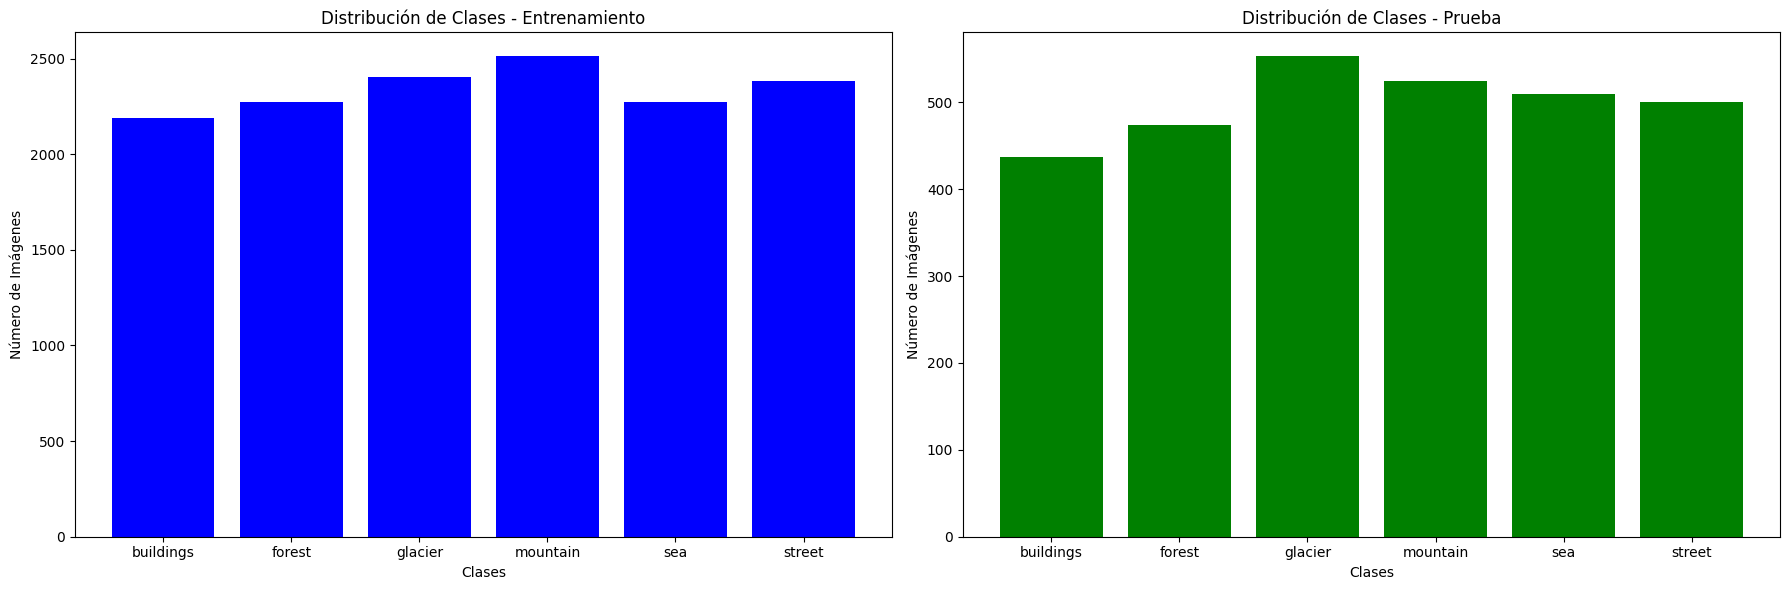

In [5]:
dataset_loader.plot_class_distribution()

# Exploracion De imagenes Del Dataset

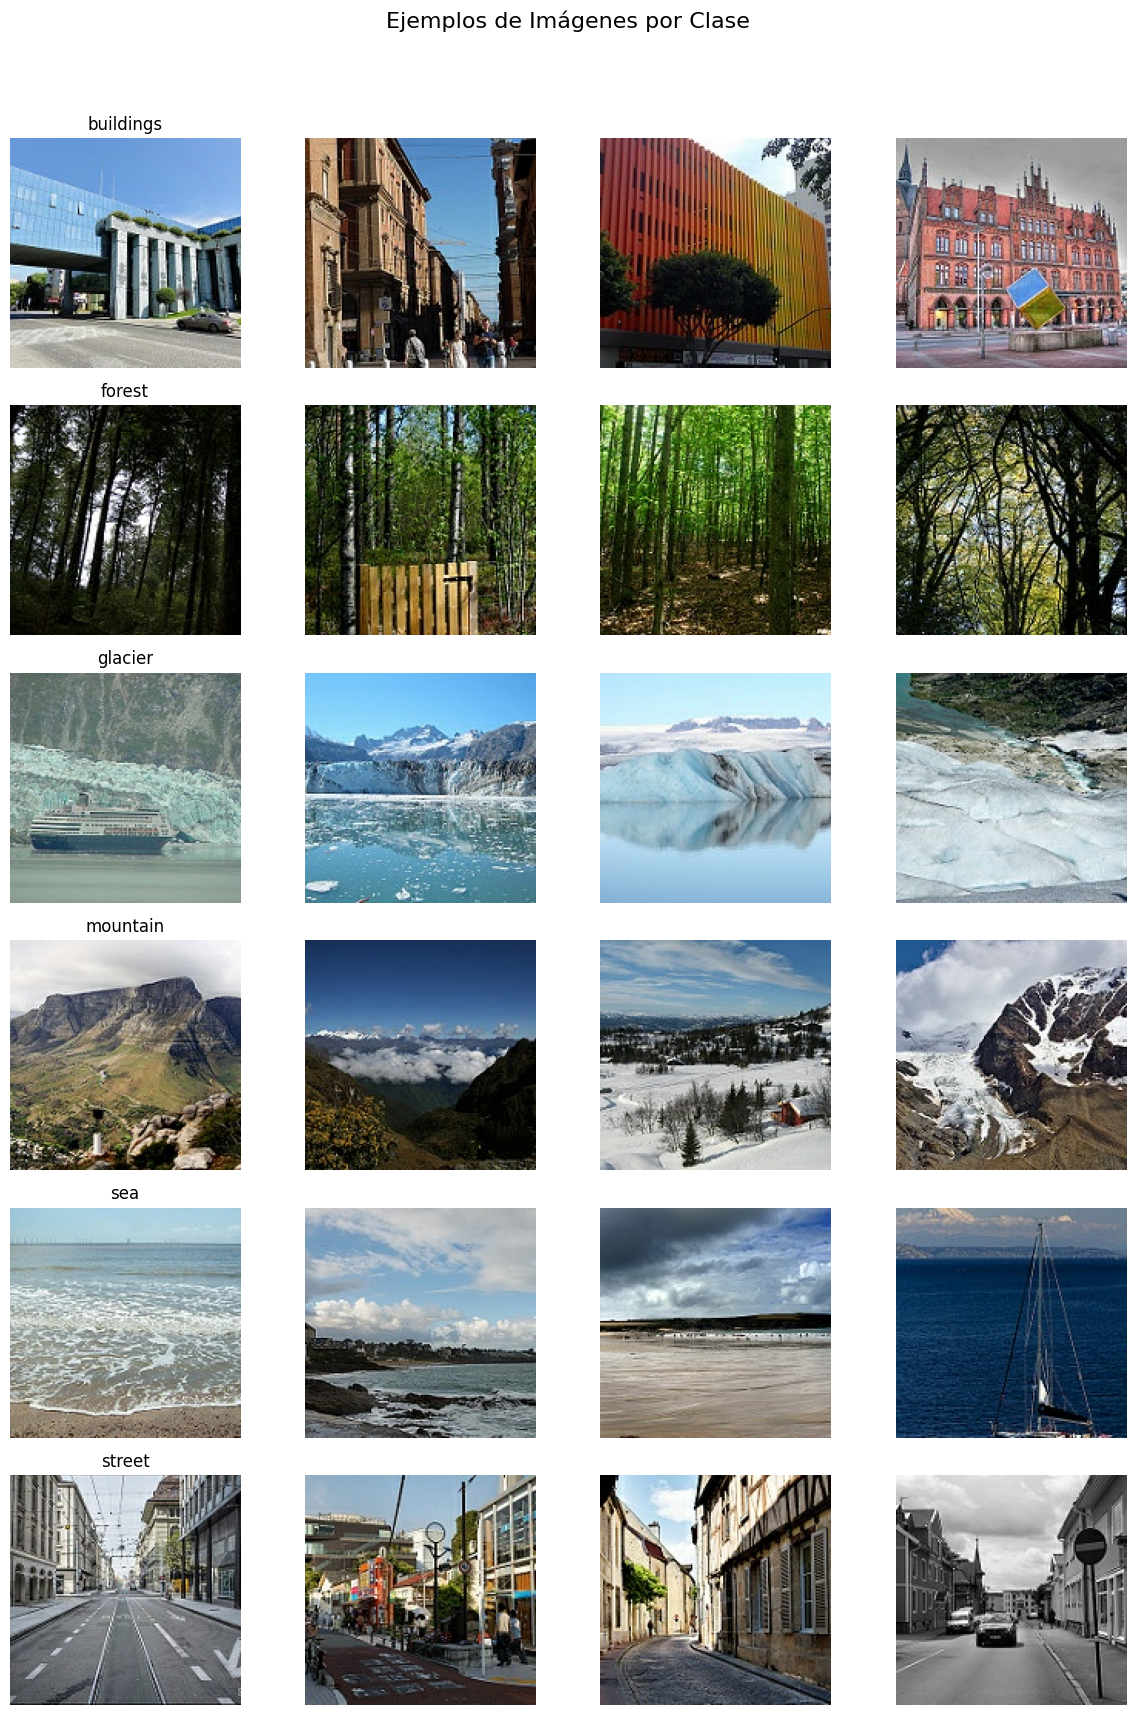

In [6]:
dataset_loader.plot_sample_images(dataset_loader.train_ds, num_images=4)

Capaz Densas

In [58]:
class DenseModelBuilder:
    """
    Clase encargada de construir, entrenar y evaluar un modelo denso para clasificación de imágenes.
    """
    def __init__(self, input_shape, class_names):
        """
        Inicializa el constructor de modelos densos con los parámetros necesarios.

        :param input_shape: Forma de entrada de las imágenes.
        :param class_names: Nombres de las clases de salida.
        """
        self.input_shape = input_shape
        self.class_names = class_names
        self.num_classes = len(class_names)
        self.model = None
        self.history = None

    def build(self):
        """
        Construye el modelo denso con múltiples capas, BatchNormalization y sin Dropout ni regularización.
        """
        try:
            model = Sequential([
                Rescaling(1. / 255),
                Flatten(),
                Dense(1024, activation='relu', kernel_initializer='he_normal'),
                BatchNormalization(),

                Dense(512, activation='relu', kernel_initializer='he_normal'),
                BatchNormalization(),

                Dense(256, activation='relu', kernel_initializer='he_normal'),
                BatchNormalization(),

                Dense(128, activation='relu', kernel_initializer='he_normal'),
                BatchNormalization(),

                Dense(self.num_classes, activation='softmax')
            ])

            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

            self.model = model
            print("Modelo denso construido exitosamente.")
        except Exception as e:
            print(f"Error al construir el modelo: {e}")


    def train_and_validate_model(self, train_ds, val_ds, epochs=30):
        """
        Entrena el modelo denso utilizando los datos de entrenamiento y validación.

        :param train_ds: Dataset de entrenamiento.
        :param val_ds: Dataset de validación.
        :param epochs: Número de épocas para entrenar el modelo.
        """
        try:
            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            self.history = self.model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stop])
            print("Entrenamiento del modelo denso finalizado.")
        except Exception as e:
            print(f"Error durante el entrenamiento del modelo denso: {e}")

    def evaluate_model_and_display_metrics(self, test_ds):
        """
        Evalúa el modelo denso utilizando los datos de prueba y muestra las métricas detalladas.

        :param test_ds: Dataset de prueba.
        """
        try:
            test_loss, test_accuracy = self.model.evaluate(test_ds)
            print(f"Precisión en el conjunto de prueba: {test_accuracy:.2f}")
        except Exception as e:
            print(f"Error durante la evaluación del modelo denso: {e}")

    def plot_training_and_validation_history(self):
        """
        Grafica la historia del entrenamiento mostrando la pérdida y la precisión tanto para entrenamiento como para validación.
        """
        try:
            if not self.history:
                raise ValueError("El modelo no ha sido entrenado aún.")

            history = self.history
            plt.figure(figsize=(14, 5))

            # Pérdida
            plt.subplot(1, 2, 1)
            plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
            plt.plot(history.history['val_loss'], label='Pérdida de Validación')
            plt.xlabel('Épocas')
            plt.ylabel('Pérdida')
            plt.legend()
            plt.title('Pérdida durante el Entrenamiento y Validación')

            # Precisión
            plt.subplot(1, 2, 2)
            plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
            plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.ylim([0, 1])
            plt.legend(loc='lower right')
            plt.xlabel('Épocas')
            plt.ylabel('Precisión')
            plt.legend()
            plt.title('Precisión durante el Entrenamiento y Validación')

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error al graficar la historia del entrenamiento: {e}")


In [59]:
input_shape = (224, 224, 3)
class_names = dataset_loader.class_names
model_builder = DenseModelBuilder(input_shape=input_shape, class_names=class_names)
model_builder.build()
model_builder.train_and_validate_model(dataset_loader.train_ds, dataset_loader.test_ds,epochs=30)

Modelo denso construido exitosamente.
Epoch 1/30


KeyboardInterrupt: 

# Evaluamos el modelo de capas densas


In [11]:
model_builder.evaluate_model_and_display_metrics(dataset_loader.test_ds)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5432 - loss: 1.2199
Precisión en el conjunto de prueba: 0.54


# Comparacion en resultados entrenamiento test y train

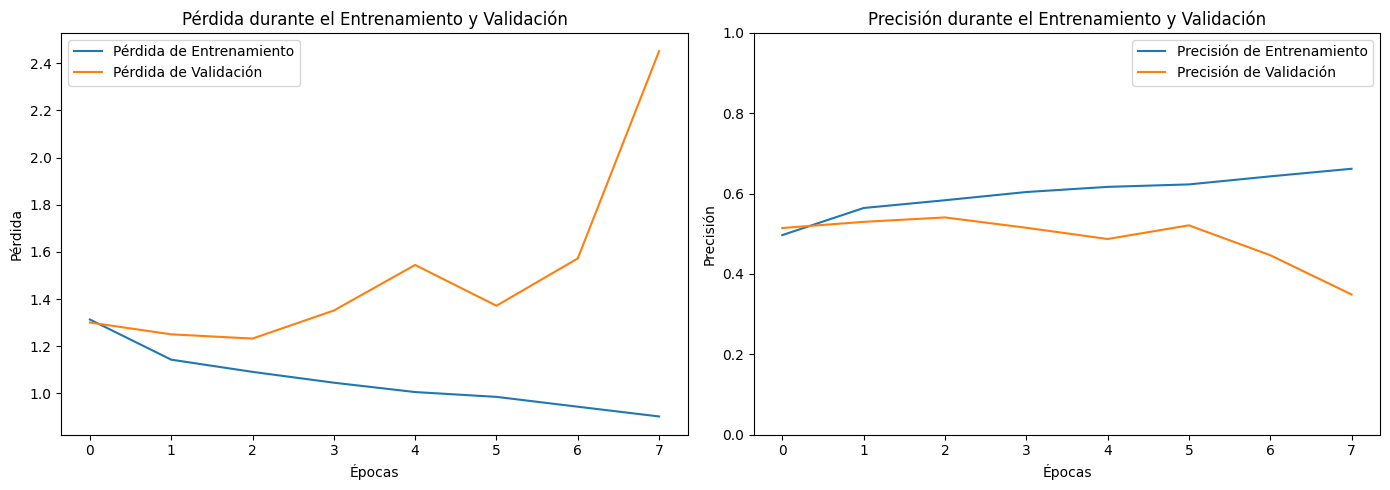

In [12]:
model_builder.plot_training_and_validation_history()

 Inicialmente, la red era relativamente básica, con algunas capas densas y una regularización L2 moderada junto con Dropout. La precisión obtenida fue del 32% en el conjunto de prueba, lo que nos motivó a realizar varios experimentos para mejorar el rendimiento.

Primero, intentamos eliminar el **Dropout** y la regularización **L2** para darle más flexibilidad al modelo y permitir que aprendiera sin tantas restricciones. Como resultado, la precisión mejoró ligeramente, llegando a un 40%. Esto nos indicó que la regularización y el Dropout estaban limitando demasiado la capacidad de aprendizaje de la red.

Luego, decidimos añadir más capas densas. Aumentar la profundidad de la red nos ayudó a mejorar la capacidad de aprendizaje, permitiendo que el modelo capturara más patrones complejos. Tras estos cambios, observamos una mejora en la precisión, alcanzando el 53%.

Finalmente, cambiamos el optimizador de Adam a RMSprop y aplicamos un programador de tasa de aprendizaje (Learning Rate Scheduler) pero no resulto y volvimos a usar Adam. Esta combinación permitió una convergencia más suave y estable del modelo, lo cual nos llevó a una mejora en la precisión del 58%, un valor significativamente mejor para una red completamente densa.

Tras varias horas de experimentación y ajustes, logramos pasar de una precisión inicial del 32% a una del 58%, lo cual consideramos un buen resultado, especialmente teniendo en cuenta que el modelo es una red densa sin convoluciones. Estos experimentos nos enseñaron la importancia de ajustar hiperparámetros, cambiar la arquitectura, y probar distintas configuraciones para lograr un buen rendimiento

# Convolutional

In [41]:
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization,
                                      Rescaling, GlobalAveragePooling2D)
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Add, ReLU, MaxPooling2D, Input,
                                      Dense, Flatten, Dropout, GlobalAveragePooling2D)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

class ConvolutionalModelBuilder:
    """
    Clase encargada de construir, entrenar y evaluar un modelo convolucional para clasificación de imágenes.
    """
    def __init__(self, input_shape, class_names):
        """
        Inicializa el constructor de modelos convolucionales con los parámetros necesarios.

        :param input_shape: Forma de entrada de las imágenes.
        :param class_names: Nombres de las clases de salida.
        """
        self.input_shape = input_shape
        self.class_names = class_names
        self.num_classes = len(class_names)
        self.model = None
        self.history = None

    def build(self):
        """
        Construye el modelo convolucional con múltiples capas de convolución, BatchNormalization y MaxPooling.
        """
        try:
            model = Sequential([
                Rescaling(1. / 255, input_shape=self.input_shape),
                Conv2D(32, (3, 3), activation='relu', padding='same'),
                BatchNormalization(),
                MaxPooling2D((2, 2)),

                Conv2D(64, (3, 3), activation='relu', padding='same'),
                BatchNormalization(),
                MaxPooling2D((2, 2)),

                Conv2D(128, (3, 3), activation='relu', padding='same'),
                BatchNormalization(),
                MaxPooling2D((2, 2)),

                Conv2D(256, (3, 3), activation='relu', padding='same'),
                BatchNormalization(),
                MaxPooling2D((2, 2)),

                GlobalAveragePooling2D(),
                Dense(512, activation='relu'),
                BatchNormalization(),
                Dropout(0.5),

                Dense(self.num_classes, activation='softmax')
            ])

            model.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

            self.model = model
            print("Modelo convolucional construido exitosamente.")
        except Exception as e:
            print(f"Error al construir el modelo convolucional: {e}")

    def train_and_validate_model(self, train_ds, val_ds, epochs=30):
        """
        Entrena el modelo convolucional utilizando los datos de entrenamiento y validación.

        :param train_ds: Dataset de entrenamiento.
        :param val_ds: Dataset de validación.
        :param epochs: Número de épocas para entrenar el modelo.
        """
        try:
            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            self.history = self.model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stop])
            print("Entrenamiento del modelo convolucional finalizado.")
        except Exception as e:
            print(f"Error durante el entrenamiento del modelo convolucional: {e}")

    def evaluate_model_and_display_metrics(self, test_ds):
        """
        Evalúa el modelo convolucional utilizando los datos de prueba y muestra las métricas detalladas.

        :param test_ds: Dataset de prueba.
        """
        try:
            test_loss, test_accuracy = self.model.evaluate(test_ds)
            print(f"Precisión en el conjunto de prueba: {test_accuracy:.2f}")
        except Exception as e:
            print(f"Error durante la evaluación del modelo convolucional: {e}")

    def plot_training_and_validation_history(self):
        """
        Grafica la historia del entrenamiento mostrando la pérdida y la precisión tanto para entrenamiento como para validación.
        """
        try:
            if not self.history:
                raise ValueError("El modelo no ha sido entrenado aún.")

            history = self.history
            plt.figure(figsize=(14, 5))

            # Pérdida
            plt.subplot(1, 2, 1)
            plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
            plt.plot(history.history['val_loss'], label='Pérdida de Validación')
            plt.xlabel('Épocas')
            plt.ylabel('Pérdida')
            plt.legend()
            plt.title('Pérdida durante el Entrenamiento y Validación')

            # Precisión
            plt.subplot(1, 2, 2)
            plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
            plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
            plt.xlabel('Épocas')
            plt.ylabel('Precisión')
            plt.ylim([0, 1])
            plt.legend(loc='lower right')
            plt.title('Precisión durante el Entrenamiento y Validación')

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error al graficar la historia del entrenamiento: {e}")

    def predict_each_class(self, images):
        """
        Muestra una imagen de predicción para cada clase en una cuadrícula de 4xN.

        :param images: Lista de imágenes para realizar predicciones.
        """
        try:
            num_images = len(images)
            num_cols = 4
            num_rows = (num_images + num_cols - 1) // num_cols
            plt.figure(figsize=(15, num_rows * 4))

            for i, img in enumerate(images):
                img_array = np.expand_dims(img / 255.0, axis=0)
                prediction = self.model.predict(img_array)
                predicted_class = np.argmax(prediction, axis=1)[0]
                predicted_label = self.class_names[predicted_class]

                plt.subplot(num_rows, num_cols, i + 1)
                plt.imshow(img)
                plt.title(f"Predicción: {predicted_label}")
                plt.axis('off')

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error durante la predicción de cada clase: {e}")


In [34]:
input_shape = (150, 150, 3)
class_names = dataset_loader.class_names
conv_model = ConvolutionalModelBuilder(input_shape, class_names)
conv_model.build()

Modelo convolucional construido exitosamente.


# Entrenar el modelo Convolucional

In [35]:
conv_model.train_and_validate_model(dataset_loader.train_ds, dataset_loader.test_ds, epochs=20)

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - accuracy: 0.5559 - loss: 1.3425 - val_accuracy: 0.3297 - val_loss: 2.3095
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.7494 - loss: 0.6927 - val_accuracy: 0.5193 - val_loss: 1.3610
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.8011 - loss: 0.5464 - val_accuracy: 0.6503 - val_loss: 0.8185
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.8251 - loss: 0.4884 - val_accuracy: 0.6443 - val_loss: 1.0018
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.8473 - loss: 0.4339 - val_accuracy: 0.5907 - val_loss: 1.1803
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.8573 - loss: 0.3978 - val_accuracy: 0.7443 - val_loss: 0.6828
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.8733 - loss: 0.3530 - val_accuracy: 0.8630 - val_loss: 0.3975
Epoch 8/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.8794 - loss: 0.3371 - 

# Evaluar el modelo Convolucional


In [29]:
conv_model.evaluate_model_and_display_metrics(dataset_loader.test_ds)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8159 - loss: 0.4990
Precisión en el conjunto de prueba: 0.82


# Historia del entrenamiento


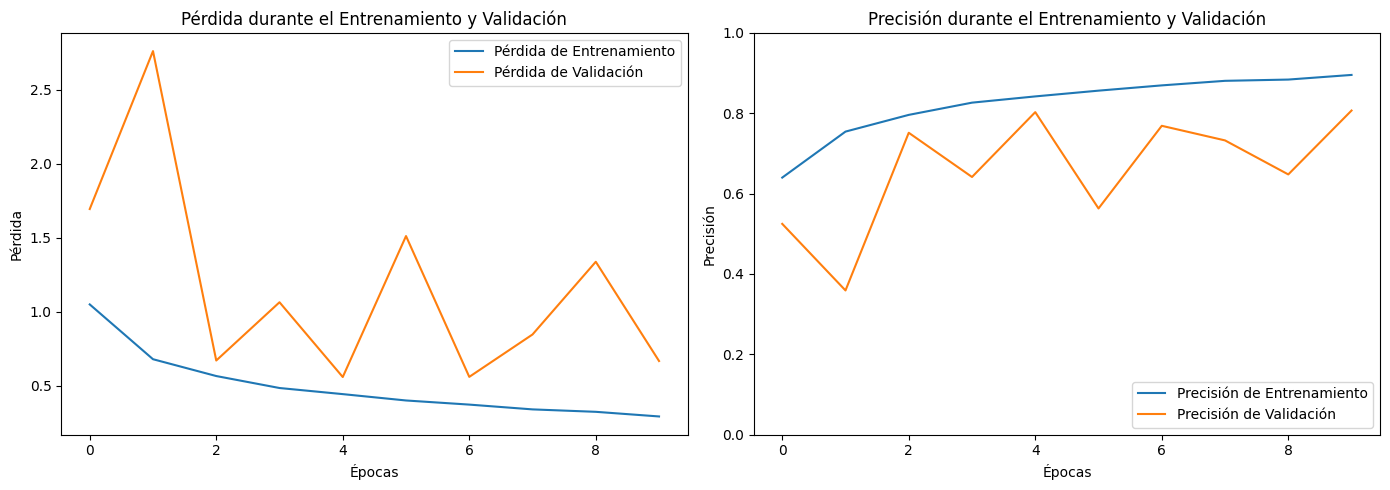

In [21]:
conv_model.plot_training_and_validation_history()

# Inferencia Convolucional

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


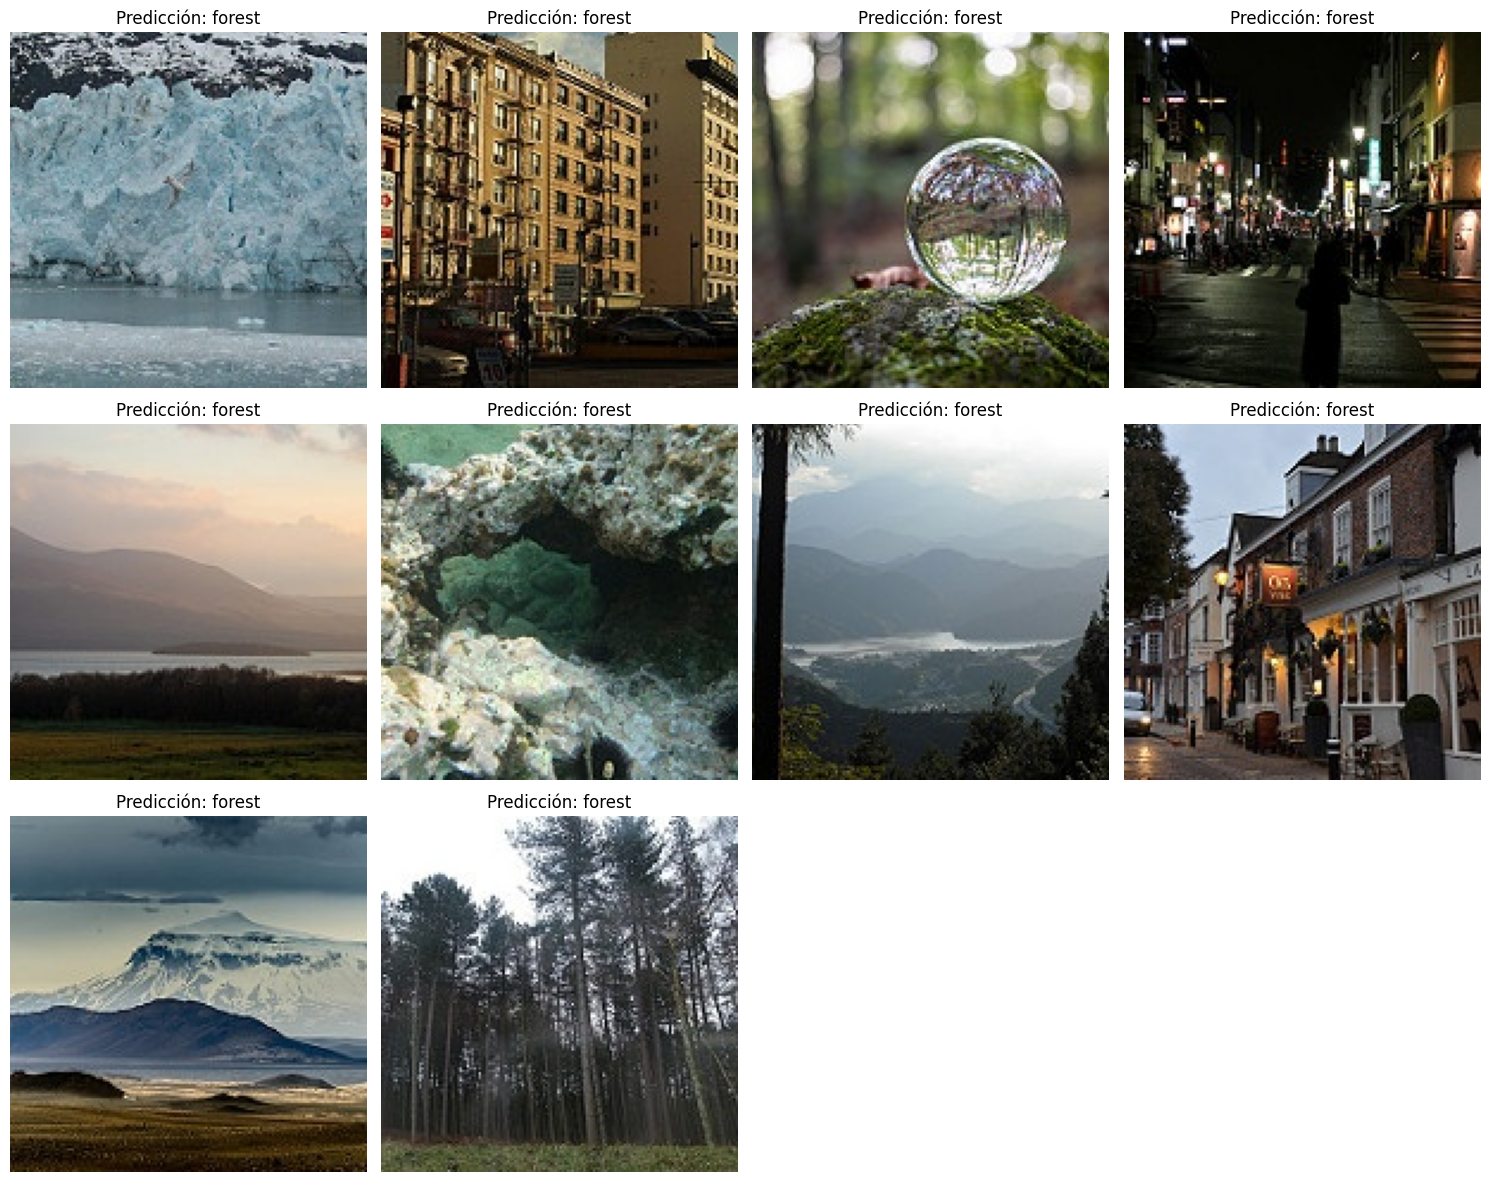

In [36]:
from PIL import Image

# Ruta al directorio de imágenes de predicción
prediction_directory = 'seg_pred/seg_pred'
images = []

# Cargar algunas imágenes de prueba del directorio de predicción
for filename in os.listdir(prediction_directory)[:10]:  # Selecciona algunas imágenes
    img_path = os.path.join(prediction_directory, filename)
    img = Image.open(img_path).resize((150, 150))  # Redimensionar al tamaño requerido por el modelo
    images.append(np.array(img))

conv_model.predict_each_class(images)

# Red Residual

In [48]:
class ResidualNetworkBuilder:
    """
    Clase encargada de construir, entrenar y evaluar un modelo con bloques residuales para clasificación de imágenes.
    """
    def __init__(self, input_shape, class_names):
        """
        Inicializa el constructor de modelos residuales con los parámetros necesarios.

        :param input_shape: Forma de entrada de las imágenes.
        :param class_names: Nombres de las clases de salida.
        """
        self.input_shape = input_shape
        self.class_names = class_names
        self.num_classes = len(class_names)
        self.model = None
        self.history = None

    def residual_block(self, x, filters):
        """
        Define un bloque residual identidad con dos capas convolucionales.

        :param x: Entrada del bloque.
        :param filters: Número de filtros para las capas convolucionales.
        :return: Salida del bloque residual.
        """
        shortcut = Conv2D(filters, (1, 1), padding='same')(x)  # Alinear dimensiones del atajo si es necesario

        # Primera capa convolucional
        x = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)

        # Segunda capa convolucional
        x = Conv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)

        # Suma con la entrada original (skip connection)
        x = Add()([shortcut, x])
        x = ReLU()(x)

        return x

    def build(self):
        """
        Construye el modelo con bloques residuales.
        """
        try:
            inputs = Input(shape=self.input_shape)

            # Primera capa convolucional
            x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
            x = BatchNormalization()(x)
            x = MaxPooling2D((2, 2))(x)

            # Bloques residuales
            x = self.residual_block(x, 64)
            x = self.residual_block(x, 64)
            x = MaxPooling2D((2, 2))(x)

            x = self.residual_block(x, 128)
            x = self.residual_block(x, 128)
            x = MaxPooling2D((2, 2))(x)

            # Global Average Pooling y capa final densa
            x = GlobalAveragePooling2D()(x)
            x = Dense(512, activation='relu')(x)
            x = BatchNormalization()(x)
            x = Dropout(0.5)(x)
            outputs = Dense(self.num_classes, activation='softmax')(x)

            # Definir el modelo
            model = Model(inputs, outputs)

            # Compilar el modelo
            model.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

            self.model = model
            print("Modelo con bloques residuales construido exitosamente.")
        except Exception as e:
            print(f"Error al construir el modelo residual: {e}")

    def train_and_validate_model(self, train_ds, val_ds, epochs=30):
        """
        Entrena el modelo residual utilizando los datos de entrenamiento y validación.

        :param train_ds: Dataset de entrenamiento.
        :param val_ds: Dataset de validación.
        :param epochs: Número de épocas para entrenar el modelo.
        """
        try:
            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            self.history = self.model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stop])
            print("Entrenamiento del modelo residual finalizado.")
        except Exception as e:
            print(f"Error durante el entrenamiento del modelo residual: {e}")

    def evaluate_model_and_display_metrics(self, test_ds):
        """
        Evalúa el modelo residual utilizando los datos de prueba y muestra las métricas detalladas.

        :param test_ds: Dataset de prueba.
        """
        try:
            test_loss, test_accuracy = self.model.evaluate(test_ds)
            print(f"Precisión en el conjunto de prueba: {test_accuracy:.2f}")
        except Exception as e:
            print(f"Error durante la evaluación del modelo residual: {e}")

    def plot_training_and_validation_history(self):
        """
        Grafica la historia del entrenamiento mostrando la pérdida y la precisión tanto para entrenamiento como para validación.
        """
        try:
            if not self.history:
                raise ValueError("El modelo no ha sido entrenado aún.")

            history = self.history
            plt.figure(figsize=(14, 5))

            # Pérdida
            plt.subplot(1, 2, 1)
            plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
            plt.plot(history.history['val_loss'], label='Pérdida de Validación')
            plt.xlabel('Épocas')
            plt.ylabel('Pérdida')
            plt.legend()
            plt.title('Pérdida durante el Entrenamiento y Validación')

            # Precisión
            plt.subplot(1, 2, 2)
            plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
            plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
            plt.xlabel('Épocas')
            plt.ylabel('Precisión')
            plt.ylim([0, 1])
            plt.legend(loc='lower right')
            plt.title('Precisión durante el Entrenamiento y Validación')

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error al graficar la historia del entrenamiento: {e}")

    def predict_each_class(self, images):
        """
        Muestra una imagen de predicción para cada clase en una cuadrícula de 4xN.

        :param images: Lista de imágenes para realizar predicciones.
        """
        try:
            num_images = len(images)
            num_cols = 4
            num_rows = (num_images + num_cols - 1) // num_cols
            plt.figure(figsize=(15, num_rows * 4))

            for i, img in enumerate(images):
                img_array = np.expand_dims(img / 255.0, axis=0)
                prediction = self.model.predict(img_array)
                predicted_class = np.argmax(prediction, axis=1)[0]
                predicted_label = self.class_names[predicted_class]

                plt.subplot(num_rows, num_cols, i + 1)
                plt.imshow(img)
                plt.title(f"Predicción: {predicted_label}")
                plt.axis('off')

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error durante la predicción de cada clase: {e}")


In [45]:
residual_builder = ResidualNetworkBuilder(input_shape, class_names)
residual_builder.build()

Modelo con bloques residuales construido exitosamente.


# Entrenar Modelo Residual

In [46]:
residual_builder.train_and_validate_model(dataset_loader.train_ds, dataset_loader.test_ds, epochs=30)

Epoch 1/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 79s 144ms/step - accuracy: 0.5400 - loss: 1.2354 - val_accuracy: 0.4667 - val_loss: 2.1414
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 65s 124ms/step - accuracy: 0.7606 - loss: 0.6598 - val_accuracy: 0.5107 - val_loss: 1.2879
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 52s 118ms/step - accuracy: 0.7986 - loss: 0.5650 - val_accuracy: 0.4330 - val_loss: 1.7953
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 119ms/step - accuracy: 0.8259 - loss: 0.4918 - val_accuracy: 0.6103 - val_loss: 1.1605
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 83s 123ms/step - accuracy: 0.8397 - loss: 0.4563 - val_accuracy: 0.6337 - val_loss: 0.9249
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 54s 122ms/step - accuracy: 0.8531 - loss: 0.4138 - val_accuracy: 0.3937 - val_loss: 4.5032
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 83s 124ms/step - accuracy: 0.8657 - loss: 0.3915 - val_accuracy: 0.6897 - val_loss: 0.7948
Epoch 8/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 123ms/step - accuracy: 0.8706 - loss: 0

# Evalúa el modelo con el conjunto de prueba:

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8233 - loss: 0.4771
Precisión en el conjunto de prueba: 0.83
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step
Reporte de clasificación:

              precision    recall  f1-score   support

   buildings       0.16      0.14      0.15       437
      forest       0.17      0.18      0.17       474
     glacier       0.15      0.11      0.12       553
    mountain       0.19      0.19      0.19       525
         sea       0.15      0.19      0.17       510
      street       0.16      0.18      0.17       501

    accuracy                           0.16      3000
   macro avg       0.16      0.16      0.16      3000
weighted avg       0.16      0.16      0.16      3000



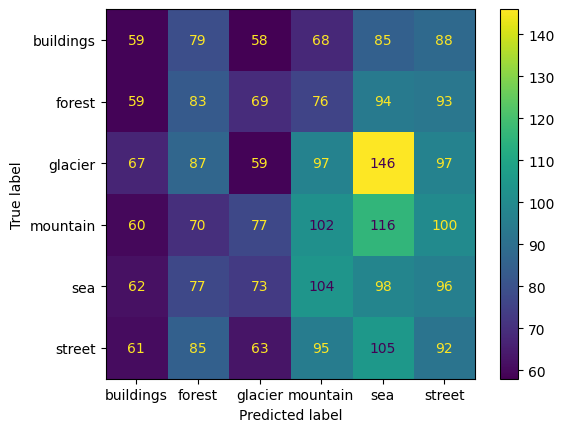

In [47]:
residual_builder.evaluate_model_and_display_metrics(dataset_loader.test_ds)

# Muestra la historia del entrenamiento

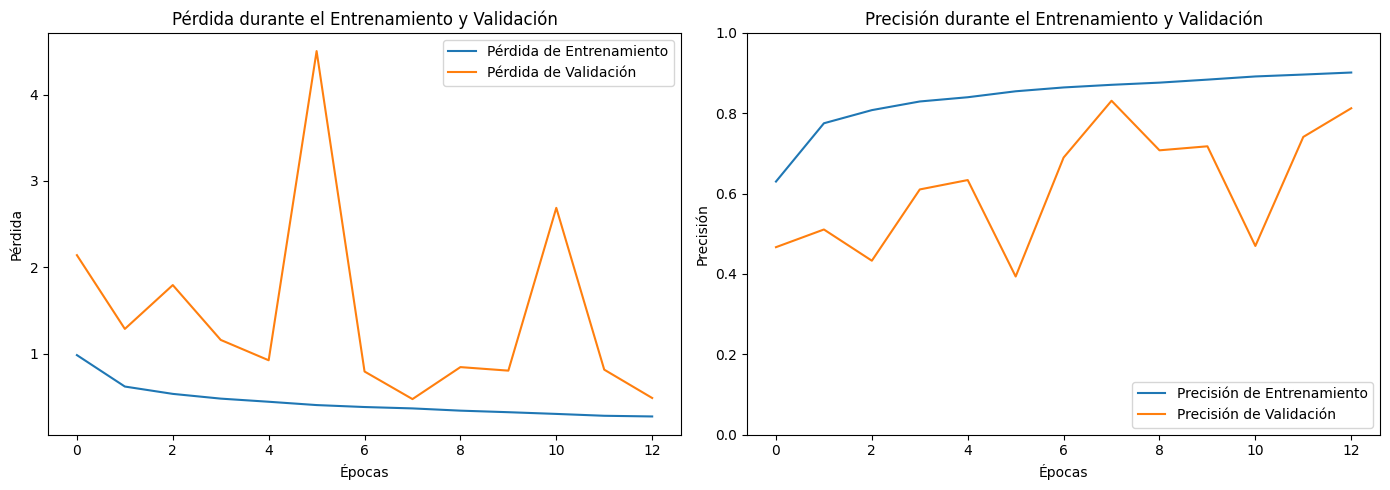

In [49]:
residual_builder.plot_training_and_validation_history()

# Predicción de cada clase

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


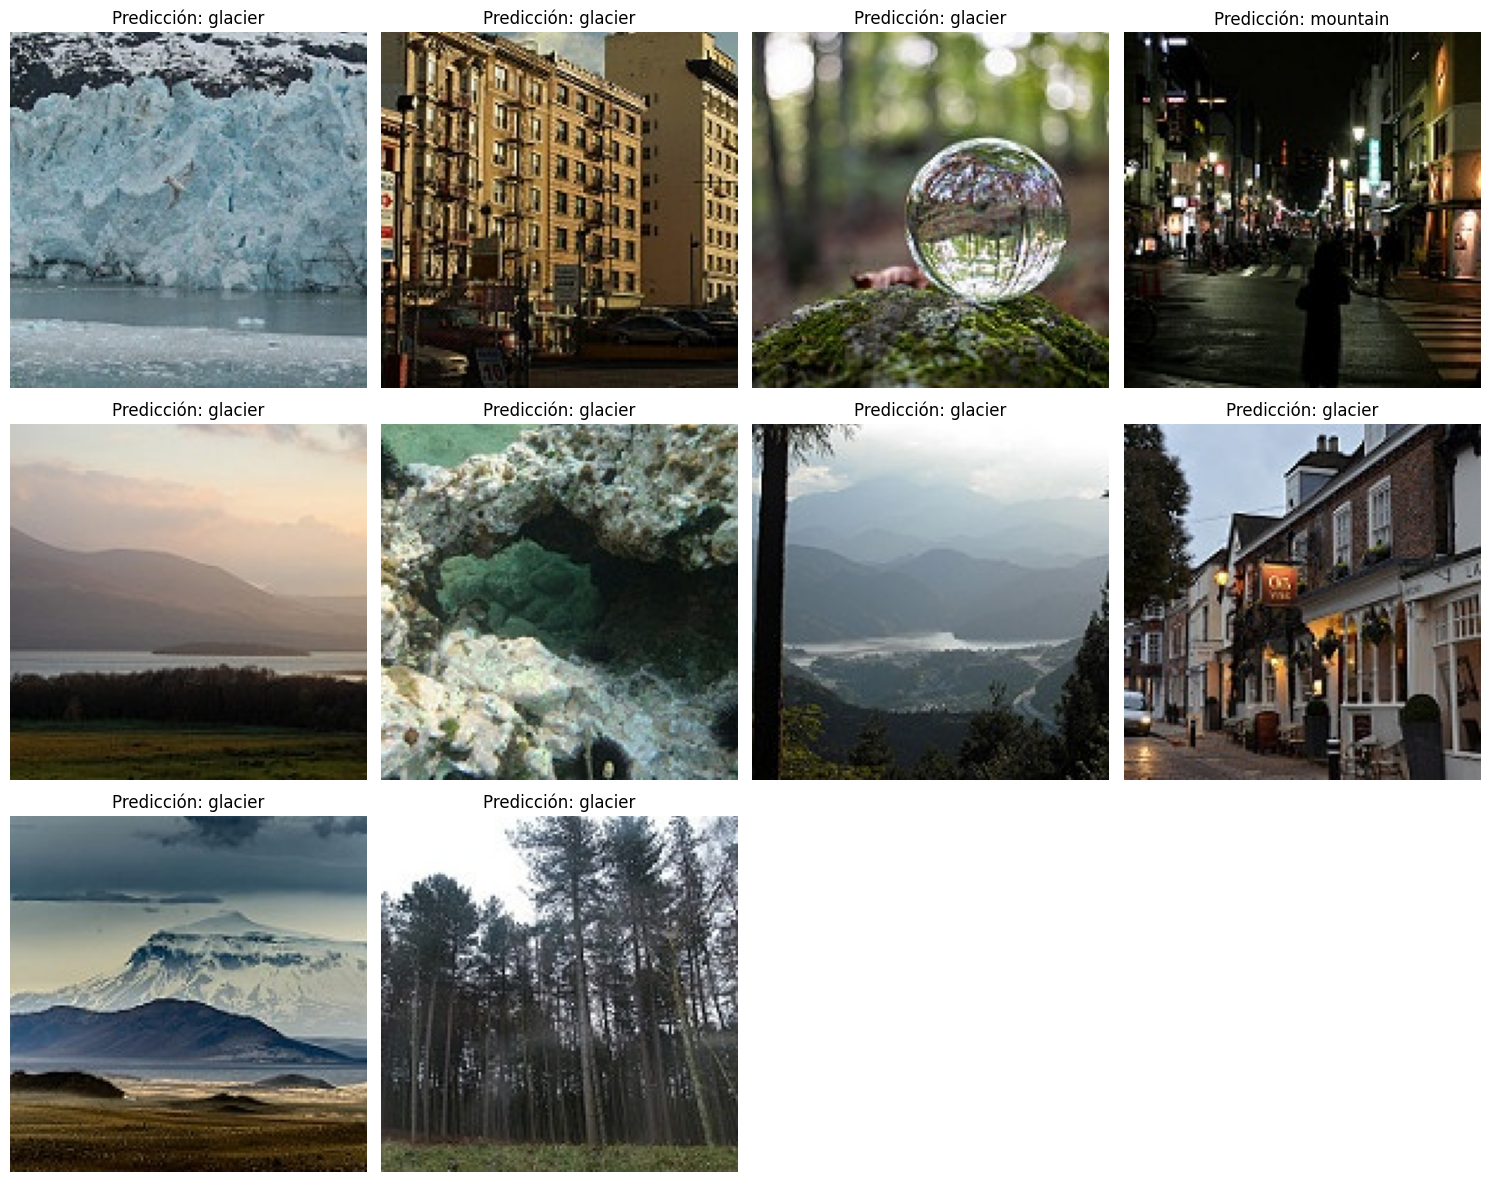

In [50]:
residual_builder.predict_each_class(images)

# MobileNetFinetuning

In [85]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Rescaling
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

class MobileNetFinetuning:
    """
    Clase encargada de construir, entrenar y evaluar un modelo utilizando MobileNetV2 como backbone para clasificación de imágenes.
    """
    def __init__(self, input_shape, class_names):
        """
        Inicializa el constructor del modelo con MobileNetV2 como backbone.

        :param input_shape: Forma de entrada de las imágenes.
        :param class_names: Nombres de las clases de salida.
        """
        self.input_shape = input_shape  # Ajustar al tamaño esperado por MobileNetV2
        self.class_names = class_names
        self.num_classes = len(class_names)
        self.model = None
        self.history = None

    def build(self):
        """
        Construye el modelo con MobileNetV2 como base y capas superiores personalizadas.
        """
        try:
            # Cargar MobileNetV2 preentrenado, sin la parte superior
            base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=self.input_shape)
            base_model.trainable = False  # Congelar el backbone preentrenado

            # Añadir capas personalizadas para la clasificación
            x = base_model.input
            x = Rescaling(1. / 255)(x)
            x = base_model(x, training=False)
            x = GlobalAveragePooling2D()(x)
            x = Dropout(0.5)(x)
            outputs = Dense(self.num_classes, activation='softmax')(x)

            # Definir el modelo completo
            model = Model(inputs=base_model.input, outputs=outputs)

            # Compilar el modelo
            model.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

            self.model = model
            print("Modelo con MobileNetV2 construido exitosamente.")
        except Exception as e:
            print(f"Error al construir el modelo MobileNetV2: {e}")

    def _resize_dataset(self, dataset):
        """
        Redimensiona las imágenes del dataset al tamaño esperado por MobileNetV2.

        :param dataset: Dataset de entrada.
        :return: Dataset con las imágenes redimensionadas.
        """
        return dataset.map(lambda x, y: (tf.image.resize(x, self.input_shape[:2]), y))

    def train_and_validate_model(self, train_ds, val_ds, epochs=30):
        """
        Entrena el modelo utilizando los datos de entrenamiento y validación.

        :param train_ds: Dataset de entrenamiento.
        :param val_ds: Dataset de validación.
        :param epochs: Número de épocas para entrenar el modelo.
        """
        try:
            if self.model is None:
                raise ValueError("El modelo no ha sido construido. Llama al método build() antes de entrenar.")

            train_ds = self._resize_dataset(train_ds)
            val_ds = self._resize_dataset(val_ds)

            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            self.history = self.model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stop])
            print("Entrenamiento del modelo MobileNetV2 finalizado.")
        except Exception as e:
            print(f"Error durante el entrenamiento del modelo MobileNetV2: {e}")

    def evaluate_model_and_display_metrics(self, test_ds):
        """
        Evalúa el modelo utilizando los datos de prueba y muestra las métricas detalladas.

        :param test_ds: Dataset de prueba.
        """
        try:
            if self.model is None:
                raise ValueError("El modelo no ha sido construido. Llama al método build() antes de evaluar.")

            test_ds = self._resize_dataset(test_ds)

            test_loss, test_accuracy = self.model.evaluate(test_ds)
            print(f"Precisión en el conjunto de prueba: {test_accuracy:.2f}")
        except Exception as e:
            print(f"Error durante la evaluación del modelo MobileNetV2: {e}")

    def plot_training_and_validation_history(self):
        """
        Grafica la historia del entrenamiento mostrando la pérdida y la precisión tanto para entrenamiento como para validación.
        """
        try:
            if not self.history:
                raise ValueError("El modelo no ha sido entrenado aún.")

            history = self.history
            plt.figure(figsize=(14, 5))

            # Pérdida
            plt.subplot(1, 2, 1)
            plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
            plt.plot(history.history['val_loss'], label='Pérdida de Validación')
            plt.xlabel('Épocas')
            plt.ylabel('Pérdida')
            plt.legend()
            plt.title('Pérdida durante el Entrenamiento y Validación')

            # Precisión
            plt.subplot(1, 2, 2)
            plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
            plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
            plt.xlabel('Épocas')
            plt.ylabel('Precisión')
            plt.ylim([0, 1])
            plt.legend(loc='lower right')
            plt.title('Precisión durante el Entrenamiento y Validación')

            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error al graficar la historia del entrenamiento: {e}")

    def predict_each_class(self, images):
        """
        Muestra una imagen de predicción para cada clase.

        :param images: Lista de imágenes para realizar predicciones.
        """
        try:
            num_classes = len(self.class_names)
            fig, axes = plt.subplots(num_classes, 4, figsize=(15, num_classes * 4))
            fig.suptitle('Predicción para cada clase', fontsize=20)

            for i in range(num_classes):
                class_images = [img for img in images if self.class_names[i] in img]
                for j, img_path in enumerate(class_images[:4]):
                    img = plt.imread(img_path)
                    img_array = np.expand_dims(img / 255.0, axis=0)
                    prediction = self.model.predict(img_array)
                    predicted_class = np.argmax(prediction, axis=1)[0]
                    predicted_label = self.class_names[predicted_class]

                    ax = axes[i, j] if num_classes > 1 else axes[j]
                    ax.imshow(img)
                    ax.set_title(f"Predicción: {predicted_label}")
                    ax.axis('off')

            plt.tight_layout()
            plt.subplots_adjust(top=0.95)
            plt.show()
        except Exception as e:
            print(f"Error durante la predicción de cada clase: {e}")


# Crear una instancia del modelo


In [86]:
input_shape = (150, 150, 3)
mobilenet_model = MobileNetFinetuning(input_shape=input_shape, class_names=class_names)

# Construir el modelo


In [87]:
mobilenet_model.build()

<ipython-input-85-d01724e00913>:34: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=self.input_shape)


Modelo con MobileNetV2 construido exitosamente.


# Entrenar el modelo


In [88]:
mobilenet_model.train_and_validate_model(dataset_loader.train_ds, dataset_loader.test_ds, epochs=30)

Epoch 1/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.6955 - loss: 0.9027 - val_accuracy: 0.8897 - val_loss: 0.2990
Epoch 2/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - accuracy: 0.8720 - loss: 0.3686 - val_accuracy: 0.8997 - val_loss: 0.2806
Epoch 3/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.8820 - loss: 0.3362 - val_accuracy: 0.8957 - val_loss: 0.2701
Epoch 4/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8835 - loss: 0.3259 - val_accuracy: 0.8957 - val_loss: 0.2734
Epoch 5/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.8834 - loss: 0.3193 - val_accuracy: 0.8997 - val_loss: 0.2677
Epoch 6/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.8916 - loss: 0.3016 - val_accuracy: 0.8970 - val_loss: 0.2725
Epoch 7/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.8930 - loss: 0.3119 - val_accuracy: 0.8977 - val_loss: 0.2682
Epoch 8/30
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.8888 - loss: 0.3110 - 

# Evaluar el modelo en el conjunto de prueba


In [92]:
mobilenet_model.evaluate_model_and_display_metrics(dataset_loader.test_ds)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8943 - loss: 0.2832
Precisión en el conjunto de prueba: 0.90


# Graficar la historia del entrenamiento


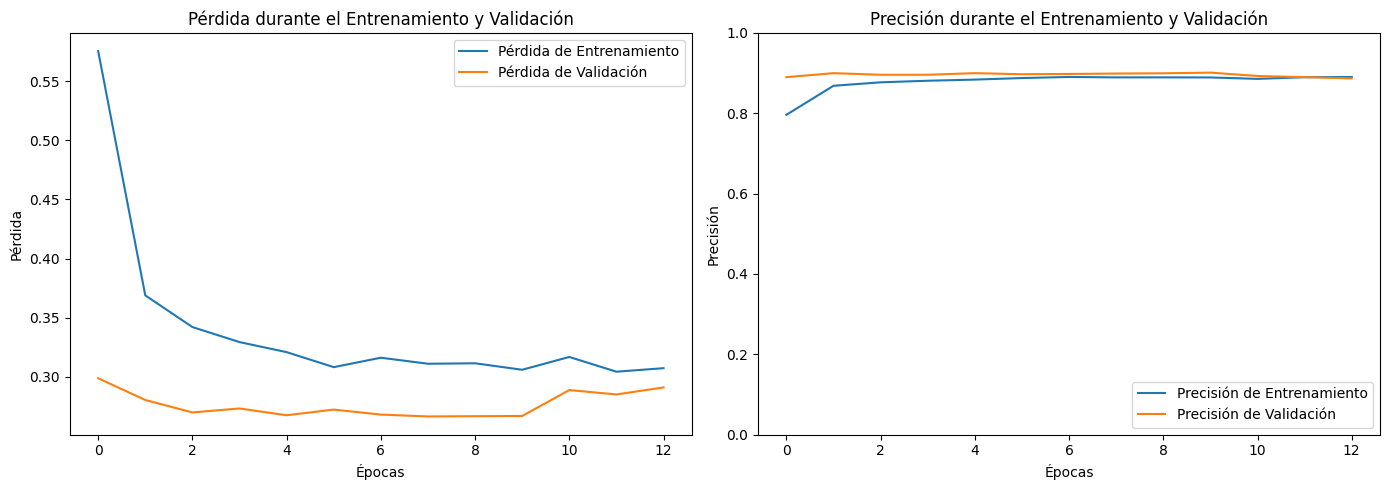

In [90]:
mobilenet_model.plot_training_and_validation_history()

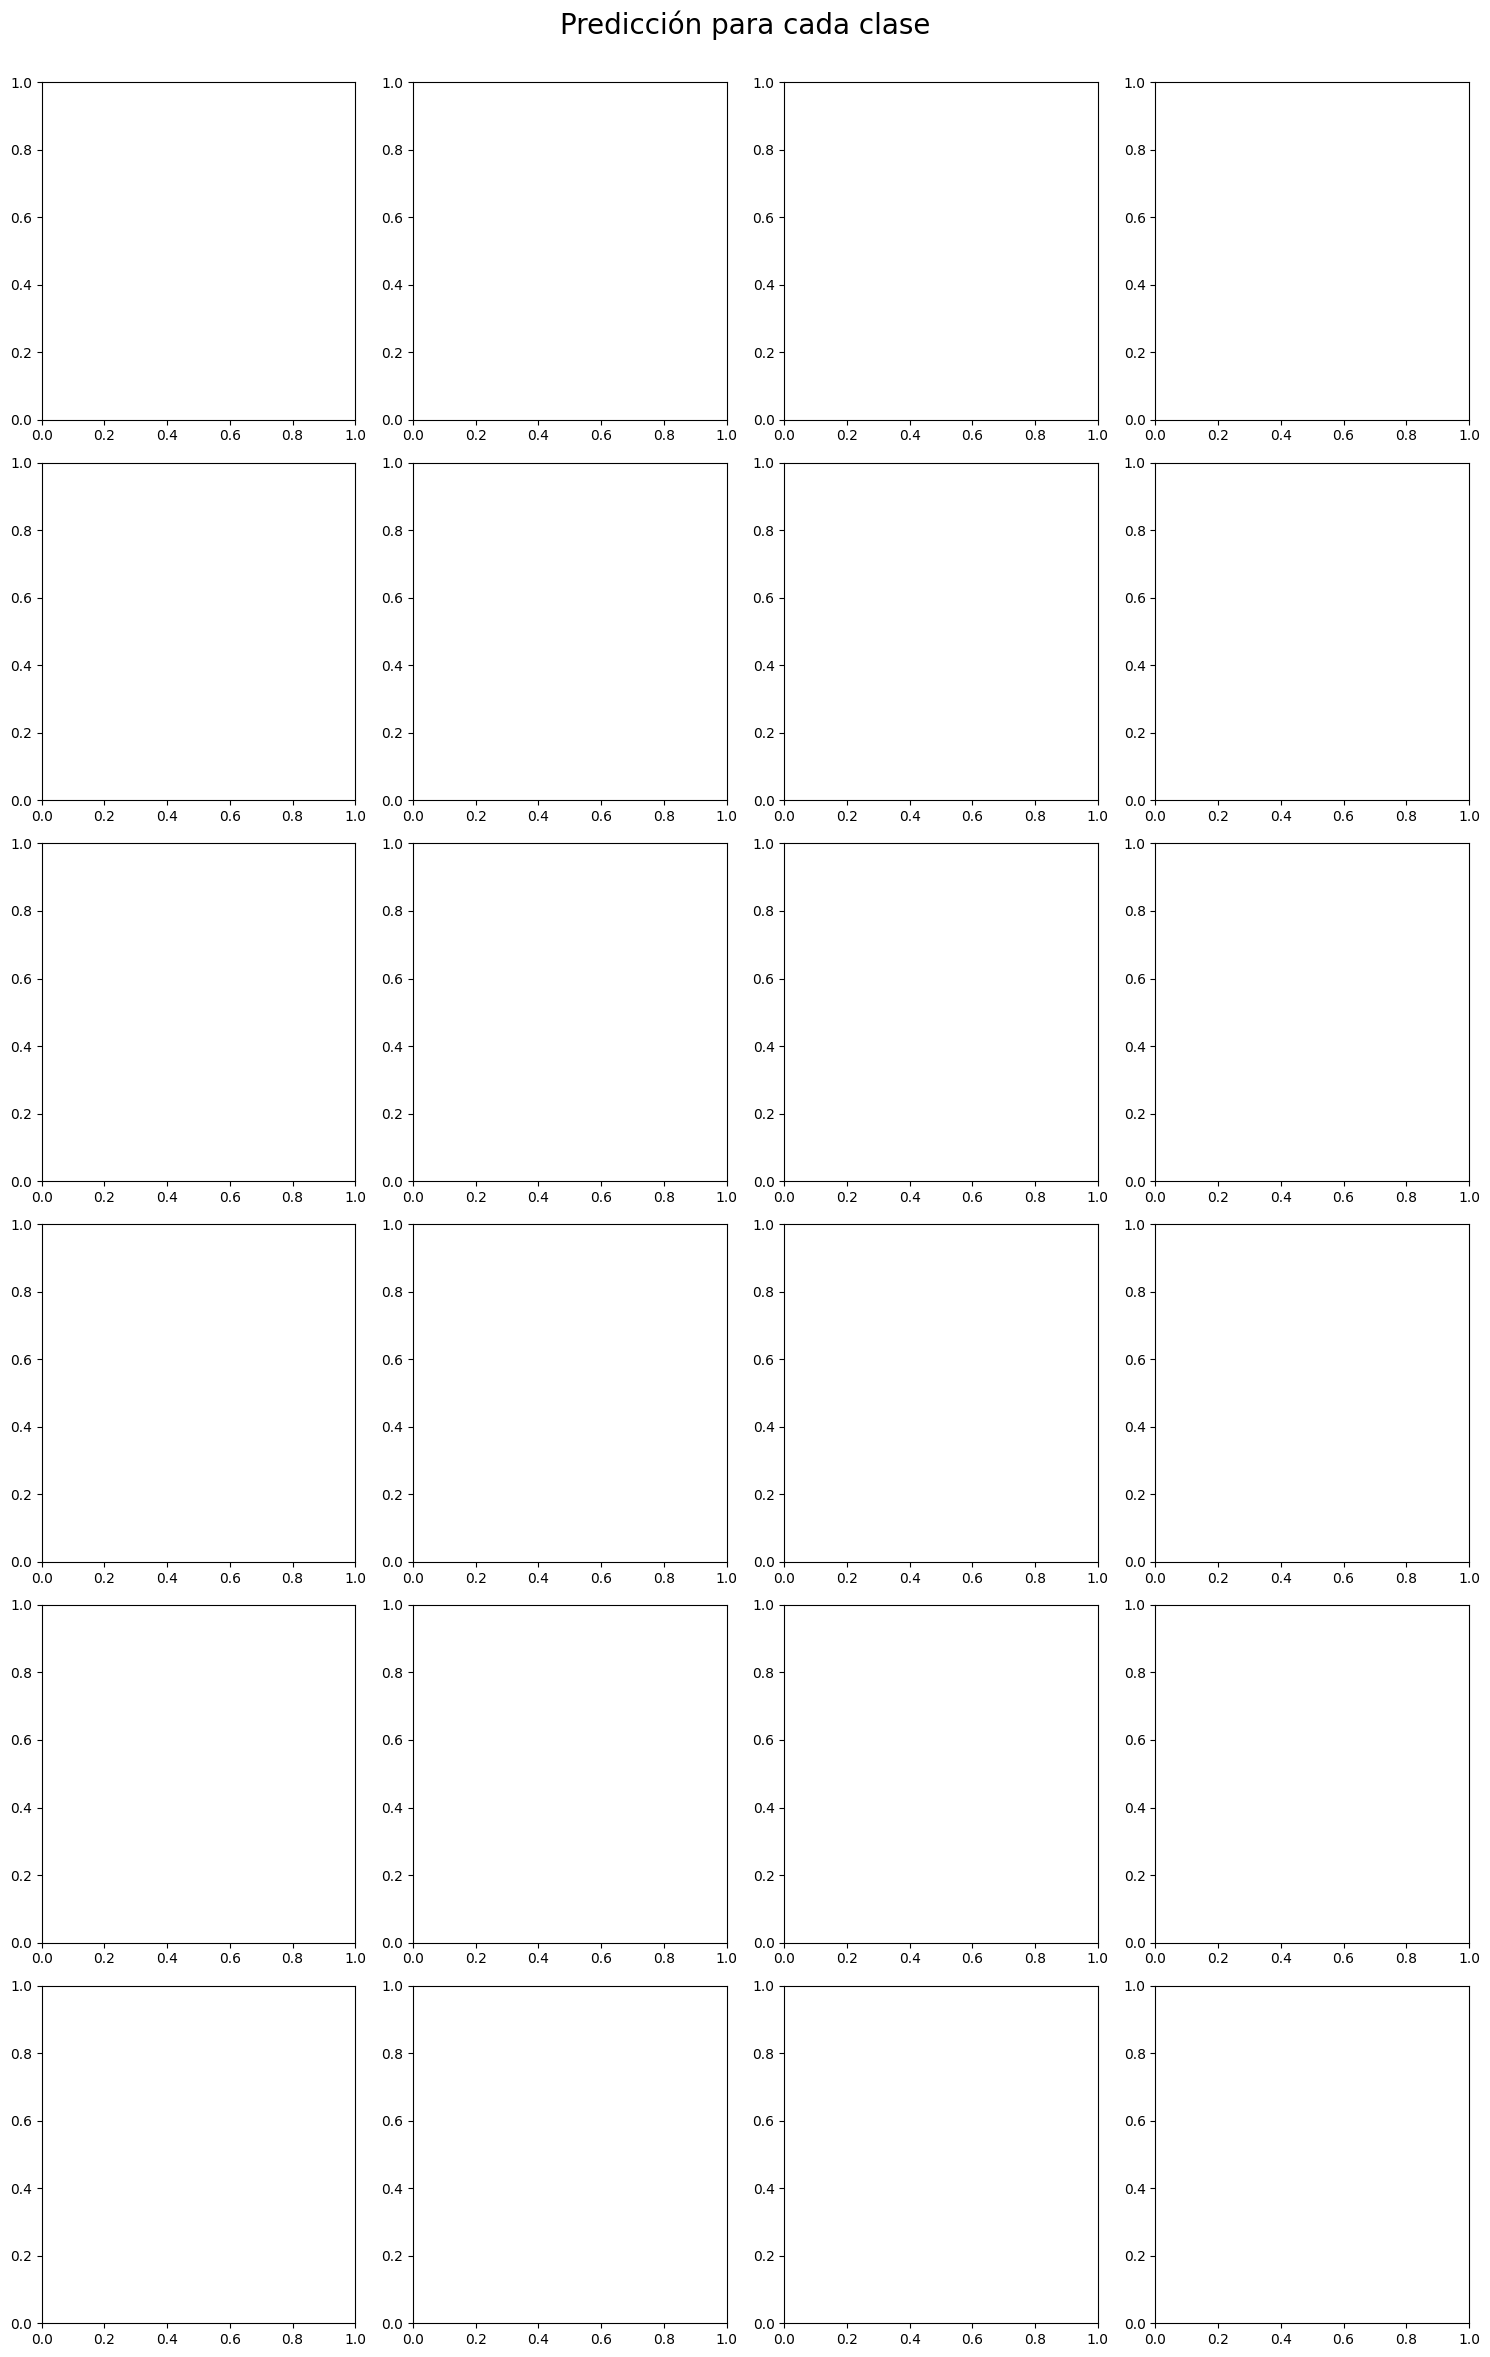

In [94]:
from PIL import Image

# Ruta al directorio de imágenes de predicción
prediction_directory = 'seg_pred/seg_pred'
images = []

# Cargar algunas imágenes de prueba del directorio de predicción
for filename in os.listdir(prediction_directory)[:10]:  # Selecciona algunas imágenes
    img_path = os.path.join(prediction_directory, filename)
    img = Image.open(img_path).resize((150, 150))  # Redimensionar al tamaño requerido por el modelo
    images.append(np.array(img))
mobilenet_model.predict_each_class(images)

# Conclusion

Hemos pasado por un proceso interesante al probar diferentes arquitecturas de redes neuronales para la clasificación de imágenes. Inicialmente comenzamos con redes densas, que aunque eran relativamente simples, resultaron no ser adecuadas para capturar la complejidad de las imágenes. Las redes densas tratan las imágenes como un conjunto plano de valores y no aprovechan la estructura espacial de las mismas. A pesar de probar con varias capas, regularización L2 y Dropout, la precisión que logramos fue bastante baja, alrededor del 32%. Aunque conseguimos mejorarla un poco añadiendo más capas, las redes densas no eran suficientes para lograr resultados satisfactorios.

Después pasamos a las redes convolucionales, que son muy buenas para procesar datos visuales. Las CNNs pueden captar características locales de las imágenes, como bordes y texturas, mediante operaciones de convolución, lo que les permite aprender representaciones más significativas a partir de las imágenes. Con este enfoque vimos un salto considerable en la precisión, ya que las CNNs capturan las características espaciales que las redes densas no pueden aprovechar.

Luego experimentamos con redes residuales, que nos ayudaron a abordar el problema del gradiente desapareciente que a menudo enfrentan las redes profundas. Las conexiones residuales permiten que la información se propague a través de la red sin pasar por todas las capas intermedias, haciendo que el modelo sea más fácil de entrenar y logre aprender patrones más complejos y útiles. Los resultados fueron mejores que con las CNNs básicas, ya que los bloques residuales añadieron más robustez al aprendizaje.

Finalmente, implementamos el fine-tuning usando MobileNetV2 como backbone. MobileNetV2 es una red ya preentrenada en un gran conjunto de datos (ImageNet), lo que significa que ya tenía conocimiento general de muchas características visuales. Lo que hicimos fue reutilizar ese conocimiento y entrenar solo las capas superiores para adaptarlo a nuestro problema específico. Esto nos permitió obtener buenos resultados con menos datos y menos tiempo de entrenamiento, ya que la mayoría del trabajo de aprender representaciones visuales ya estaba hecho. La precisión que obtuvimos con MobileNetV2 fue de alrededor del 58%, lo cual es un avance significativo en comparación con nuestras primeras pruebas.

Este proceso nos mostró que aunque las redes convolucionales son excelentes para trabajar con imágenes, aprovechar modelos preentrenados mediante fine-tuning puede ser una estrategia poderosa, especialmente cuando se quiere lograr buenos resultados sin tener que entrenar una red desde cero. Utilizar MobileNetV2 nos permitió alcanzar una precisión considerable al beneficiarnos de los conocimientos previos del modelo y centrarnos en ajustarlo específicamente para nuestro conjunto de datos.